## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

# 1. Initial Basic Steps
1. Importing necessary libraries
2. Loading data
3. Observe basic structure of data

## 1.1 Import necessary libraries

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
import time
from pprint import pprint

## 1.2 Load data and observe basic structure

In [26]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Here we will observe the distribution of our classes

# 2. Exploratory data analysis

In [28]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

Text(0.5, 1.0, 'Percentage')

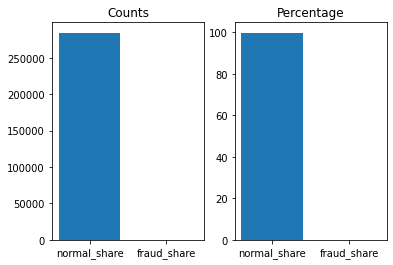

In [29]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
fig, axs = plt.subplots(1,2)
axs[0].bar(x=["normal_share", "fraud_share"], height=classes)
axs[0].set_title("Counts")
axs[1].bar(x=["normal_share", "fraud_share"], height=[normal_share, fraud_share])
axs[1].set_title("Percentage")

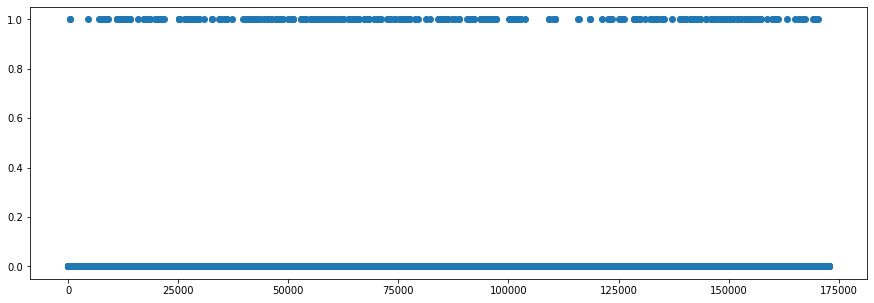

In [30]:
# Create a scatter plot to observe the distribution of classes with time
plt.figure(figsize=(15,5))
plt.scatter(df.Time, df.Class)


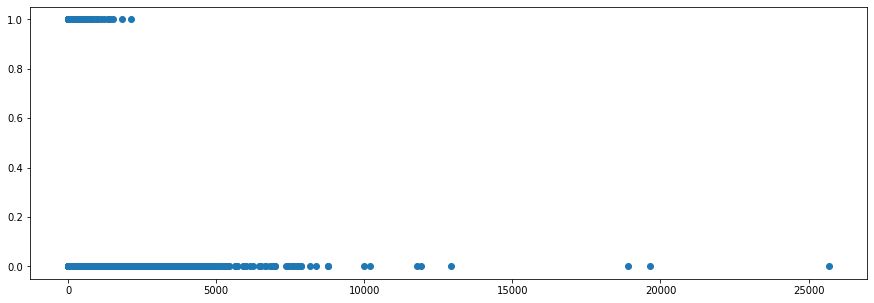

In [31]:
# Create a scatter plot to observe the distribution of classes with Amount
plt.figure(figsize=(15,5))
plt.scatter(df.Amount, df.Class)

In [32]:
# Drop unnecessary columns
df=df.drop("Time", axis=1)

### Splitting the data into train & test data

In [33]:
y=df.Class #class variable
X=df.drop("Class",axis=1)

In [34]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=100)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [35]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
369
123


### Plotting the distribution of a variable

In [ ]:
# plot the histogram of a variable from the dataset to see the skewness
fig,axs=plt.subplots(6,5)
for i in range(6):
    for j in range(5):
        try:
            axs[i,j].hist(X_train[X_train.columns[5*i+j]], bins=100)
            axs[i,j].set_title(X_train.columns[5*i+j])
        except:
            pass
fig.set_size_inches(22,24)

`We can see that there are many variables which have very high skewness so lets find the list of variable which have more than 0.5 skew and less than -0.5 skew`

In [ ]:
# See the features with more than 0.5 or less that -0.5 skew
skew=X_train.skew()
# Take absolute value of skew and then get all the columns whose absolute value of skew is more than 0.5
skewed=skew[np.abs(skew)>0.5]
print(skewed)
print("The total number of features with skewness more than 0.5 or less than -0.5 are ", len(skewed))

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [36]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
power_trans=preprocessing.PowerTransformer(copy=False)
power_trans.fit_transform(X_train)
power_trans.transform(X_test)

array([[ 1.11660077, -0.24624807, -1.21126569, ..., -0.09942353,
        -0.02426017,  1.11998389],
       [-0.8007408 ,  0.44011381,  0.62206941, ..., -0.11903135,
        -0.02932256, -1.4485192 ],
       [ 1.42613473,  0.11607881, -1.26746513, ..., -0.10881017,
        -0.23037544, -0.39489373],
       ...,
       [ 1.34967801, -0.27895312, -1.02259027, ..., -0.28713909,
        -0.22180959,  0.59394613],
       [-0.60181077,  0.80366937, -0.16233207, ..., -0.58853555,
         0.48508476, -0.72555558],
       [ 0.46727185, -0.4919582 ,  0.00805671, ..., -0.09422002,
         0.10855538,  1.15551083]])

In [ ]:
# plot the histogram of a variable from the dataset again to see the result 
fig,axs=plt.subplots(6,5)
for i in range(6):
    for j in range(5):
        try:
            axs[i,j].hist(X_train[X_train.columns[5*i+j]], bins=100)
            axs[i,j].set_title(X_train.columns[5*i+j])
        except:
            pass
fig.set_size_inches(22,24)

In [ ]:
# Now again See the features with more than 0.5 or less that -0.5 skew after power transform
skew=X_train.skew()
# Take absolute value of skew and then get all the columns whose absolute value of skew is more than 0.5
skewed=skew[np.abs(skew)>0.5]
print(skewed)
print("The total number of features with skewness more than 0.5 or less than -0.5 are ", len(skewed))

# 3. Model Building
- Build different models on the imbalanced dataset and see the result

## 3.1 Logistic regression

In [37]:
# Logistic Regression
from sklearn import linear_model #import the package

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

### 3.1.1 Cross validation done manually

In [ ]:
#perform cross validation manually
skf=model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
accuracy_scores =[]
recall_scores = []
precission_scores = []
AUC_ROC=[]
logistic_model=linear_model.LogisticRegression( random_state=100)
for train_index, test_index in skf.split(X_train,y_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    logistic_model.fit(X_train_cv, y_train_cv)
    predictions = logistic_model.predict(X_test_cv)
    pred_proba= logistic_model.predict_proba(X_test_cv)[:,1]
    accuracy_scores.append(metrics.accuracy_score(y_test_cv, predictions))
    recall_scores.append(metrics.recall_score(y_test_cv, predictions))
    precission_scores.append(metrics.precision_score(y_test_cv, predictions))
    AUC_ROC.append(metrics.roc_auc_score(y_test_cv,pred_proba))
print("The average accurcay score is", np.mean(accuracy_scores))
print("The average recall score is", np.mean(recall_scores))
print("The average precision score is", np.mean(precission_scores))
print("The average ROC AUC score is", np.mean(AUC_ROC))

### 3.1.2 Hyperparameter Tunning for Logistic regression

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
params = dict(solver=solvers,penalty=penalty,C=c_values)
pprint(params)

In [ ]:
start=time.time()
#perform hyperparameter tuning

skf=model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
logistic_model=linear_model.LogisticRegression(random_state=100, max_iter=1000)

# The best evaluation metric to evealuate the strength of a model is auc roc score
grid_search = model_selection.GridSearchCV(estimator=logistic_model, param_grid=params, n_jobs=-1, cv=skf, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train, y_train)
end=time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
grid_result.best_estimator_

In [ ]:
# See best score
grid_result.best_score_

In [ ]:
#print the optimum value of hyperparameters
print(grid_result.best_params_)

### 3.1.3 Logistic regression model using best params

In [ ]:
# Now train the model using these optimum hyperparametrs
logistic_model=linear_model.LogisticRegression(penalty='l2', C=0.01, random_state=100, solver='liblinear',max_iter=1000)
logistic_model.fit(X_train,y_train)
# Find the probability of the target to be 1
predict_proba= logistic_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=logistic_model.predict_proba(X_train)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 3.1.4 Logistic regression Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 3.2 KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# See the list of parameters
pprint(knn.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


In [21]:
# Set N neighbours
n_neighbors = np.arange(3,13,2)
# Set weights
weights = ['uniform', 'distance']
# Set distance metrics
metric = ['euclidean', 'manhattan', 'minkowski']
# grid param
param_grid = {"n_neighbors" : n_neighbors, "weights" : weights, "metric" : metric}
pprint(param_grid)

{'metric': ['euclidean', 'manhattan', 'minkowski'],
 'n_neighbors': array([ 3,  5,  7,  9, 11]),
 'weights': ['uniform', 'distance']}


### 3.2.1 Hyperparameter Tunning for KNN

In [ ]:
start= time.time()
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# Initiate the Stratified K fold
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=knn, param_grid=param_grid, n_jobs=-1, cv=skf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train, y_train)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 3.2.2 KNN using best params

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5, weights = uniform, metric=manhattan)
knn.fit(X_train, y_train)
# Find the probability of the target to be 1
predict_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=knn.predict_proba(X_train)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 3.2.3 KNN Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 3.3 XGBoost

In [49]:
from xgboost import XGBClassifier

In [51]:
xgb = XGBClassifier()
pprint(xgb.get_params())

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'use_label_encoder': True,
 'validate_parameters': None,
 'verbosity': None}


### 3.3.1 Hyperparameter Tunning for XGBoost

In [ ]:
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15]
gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
param_grid={"learning_rate":learning_rate, "max_depth":max_depth, "gamma"=gamma}
pprint(param_grid)

In [ ]:
start= time.time()
# Initiate XGBoost Classifier object
xgb = XGBClassifier()
# Initiate the Stratified K fold
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=skf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train, y_train)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 3.3.2 XGBoost using best params

In [ ]:
xgb = XGBClassifier(learning_rate = 0.20, max_depth = 5, gamma = 0.3)
xgb.fit(X_train, y_train)
# Find the probability of the target to be 1
predict_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=xgb.predict_proba(X_train)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 3.3.3 XGBoost Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

# 4. Choose the best model without Oversampling
## 4.1 Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
clf = ___  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train)
print --> #print the evaluation score on the X_test by choosing the best evaluation metric

## 4.2 Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

# Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

# 5. Random Oversampling

In [ ]:
from imblearn import over_sampling #- import the packages

In [ ]:
#balance classes on X_train_cv & y_train_cv using Random Oversampling
ro = over_sampling.RandomOverSampler(random_state=100)
X_train_ro, y_train_ro = ro.fit_resample(X_train, y_train)

In [ ]:
# Now lets see the class distribution of oversampled data
classes=y_train_ro.value_counts()
normal_share=classes[0]/len(y_train_ro)*100
fraud_share=classes[1]/len(y_train_ro)*100
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
fig, axs = plt.subplots(1,2)
axs[0].bar(x=["normal_share", "fraud_share"], height=classes)
axs[0].set_title("Counts")
axs[1].bar(x=["normal_share", "fraud_share"], height=[normal_share, fraud_share])
axs[1].set_title("Percentage")

So our data is oversampled properly.

## 5.1. Logistic Regression with Random Oversampling

In [23]:
from sklearn import linear_model

In [24]:
# Initiate Logistic regression object
logistic_model=linear_model.LogisticRegression()
# See the list of parameters
pprint(logistic_model.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### 5.1.1 Hyperparameter Tunning for Logistic regression with Random Oversampling

In [ ]:
# Solver
solvers = ['newton-cg', 'lbfgs', 'liblinear']
# Penalty Regularization
penalty = ['l2']
c_values = [ 100, 10, 0.1, 0.01]

# define grid search
params = dict(solver=solvers,penalty=penalty,C=c_values)
pprint(params)

In [ ]:
start=time.time()

# Initiate K fold
kf=model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Logistic regression model
logistic_model=linear_model.LogisticRegression(random_state=100, max_iter=1000)
# The best evaluation metric to evealuate the strength of a model is auc roc score
grid_search = model_selection.GridSearchCV(estimator=logistic_model, param_grid=params, n_jobs=-1, cv=kf, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_ro, y_train_ro)
end=time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
grid_result.best_estimator_

In [ ]:
# See best score
grid_result.best_score_

In [ ]:
#print the optimum value of hyperparameters
print(grid_result.best_params_)

### 5.1.2 Logistic Regression with best params

In [ ]:
# Now train the model using these optimum hyperparametrs
logistic_model=linear_model.LogisticRegression(penalty='l2', C=100, random_state=100, solver='newton-cg',max_iter=1000)
logistic_model.fit(X_train_ro,y_train_ro)
# Find the probability of the target to be 1
predict_proba= logistic_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.999 the classes of the target will be
# Prediction for train data
y_train_pred=logistic_model.predict_proba(X_train_ro)[:,1]>0.999
# Prediction for test data
y_pred=predict_proba>0.999

### 5.1.3 Logistic Regression with Random OverSampler model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_ro, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_ro, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 5.2 KNN with Random OverSampling

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# See the list of parameters
pprint(knn.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


### 5.2.1 Hyperparameter Tunning for KNN with Random Oversampling

In [21]:
# Set N neighbours
n_neighbors = np.arange(3,13,2)
# Set weights
weights = ['uniform', 'distance']
# Set distance metrics
metric = ['euclidean', 'manhattan', 'minkowski']
# grid param
param_grid = {"n_neighbors" : n_neighbors, "weights" : weights, "metric" : metric}
pprint(param_grid)

{'metric': ['euclidean', 'manhattan', 'minkowski'],
 'n_neighbors': array([ 3,  5,  7,  9, 11]),
 'weights': ['uniform', 'distance']}


In [ ]:
start= time.time()
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# Initiate the K fold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=knn, param_grid=param_grid, n_jobs=-1, cv=kf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train_ro, y_train_ro)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 5.2.2 KNN using best params

In [ ]:
knn = KNeighborsClassifier("n_neighbors" : n_neighbors, "weights" : weights, "metric" : metric)
knn.fit(X_train_ro, y_train_ro)
# Find the probability of the target to be 1
predict_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=knn.predict_proba(X_train_ro)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 5.2.3 KNN with Random OverSampler Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_ro, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_ro, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 5.3 XGBoost with Random Oversampling

In [49]:
from xgboost import XGBClassifier

In [51]:
xgb = XGBClassifier()
pprint(xgb.get_params())

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'use_label_encoder': True,
 'validate_parameters': None,
 'verbosity': None}


### 5.3.1 Hyperparameter Tunning for XGBoost

In [ ]:
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15]
gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
param_grid={"learning_rate":learning_rate, "max_depth":max_depth, "gamma"=gamma}
pprint(param_grid)

In [ ]:
start= time.time()
# Initiate XGBoost Classifier object
xgb = XGBClassifier()
# Initiate the Stratified K fold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=kf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train_ro, y_train_ro)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 5.3.2 XGBoost using best params

In [ ]:
xgb = XGBClassifier(learning_rate = 0.20, max_depth = 5, gamma = 0.3)
xgb.fit(X_train_ro, y_train_ro)
# Find the probability of the target to be 1
predict_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=xgb.predict_proba(X_train_ro)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 5.3.3 XGBoost with Random Oversampling Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_ro, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_ro, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

# 6. SMOTE
##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying SMOTE 

In [ ]:
import warnings
warnings.filterwarnings("ignore")


sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



fig = plt.figure(figsize=[20,20])

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
# Now lets see the class distribution of oversampled data
classes=y_train_smote.value_counts()
normal_share=classes[0]/len(y_train_smote)*100
fraud_share=classes[1]/len(y_train_smote)*100
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
fig, axs = plt.subplots(1,2)
axs[0].bar(x=["normal_share", "fraud_share"], height=classes)
axs[0].set_title("Counts")
axs[1].bar(x=["normal_share", "fraud_share"], height=[normal_share, fraud_share])
axs[1].set_title("Percentage")

## 6.1 Logistic regression with SMOTE

In [23]:
from sklearn import linear_model

In [24]:
# Initiate Logistic regression object
logistic_model=linear_model.LogisticRegression()
# See the list of parameters
pprint(logistic_model.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### 6.1.1 Hyperparameter Tunning for Logistic regression with SMOTE

In [ ]:
# Solver
solvers = ['newton-cg', 'lbfgs', 'liblinear']
# Penalty Regularization
penalty = ['l2']
c_values = [ 100, 10, 0.1, 0.01]

# define grid search
params = dict(solver=solvers,penalty=penalty,C=c_values)
pprint(params)

In [ ]:
start=time.time()
kf=model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
logistic_model=linear_model.LogisticRegression(random_state=100, max_iter=1000)
# define grid search
params = dict(solver=solvers,penalty=penalty,C=c_values)
# The best evaluation metric to evealuate the strength of a model is auc roc score
grid_search = model_selection.GridSearchCV(estimator=logistic_model, param_grid=params, n_jobs=-1, cv=kf, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_smote, y_train_smote)
end=time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
grid_result.best_estimator_

In [ ]:
# See best score
grid_result.best_score_

In [ ]:
#print the optimum value of hyperparameters
print(grid_result.best_params_)

### 6.1.2 Logistic Regression model with best params

In [ ]:
# Now train the model using these optimum hyperparametrs
logistic_model=linear_model.LogisticRegression(penalty='l2', C=100, random_state=100, solver='newton-cg',max_iter=1000)
logistic_model.fit(X_train_smote,y_train_smote)
# Find the probability of the target to be 1
predict_proba= logistic_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.999 the classes of the target will be
# Prediction for train data
y_train_pred=logistic_model.predict_proba(X_train_smote)[:,1]>0.999
# Prediction for test data
y_pred=predict_proba>0.999

### 6.1.3 Logistic regression with SMOTE model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_smote, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_smote, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 6.2 KNN with SMOTE

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# See the list of parameters
pprint(knn.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


In [21]:
# Set N neighbours
n_neighbors = np.arange(3,13,2)
# Set weights
weights = ['uniform', 'distance']
# Set distance metrics
metric = ['euclidean', 'manhattan', 'minkowski']
# grid param
param_grid = {"n_neighbors" : n_neighbors, "weights" : weights, "metric" : metric}
pprint(param_grid)

{'metric': ['euclidean', 'manhattan', 'minkowski'],
 'n_neighbors': array([ 3,  5,  7,  9, 11]),
 'weights': ['uniform', 'distance']}


### 6.2.1 Hyperparameter Tunning for KNN with SMOTE

In [ ]:
start= time.time()
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# Initiate the K fold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=knn, param_grid=param_grid, n_jobs=-1, cv=kf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train_smote, y_train_smote)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 6.2.2 KNN using best params

In [ ]:
knn = KNeighborsClassifier("n_neighbors" : n_neighbors, "weights" : weights, "metric" : metric)
knn.fit(X_train_smote, y_train_smote)
# Find the probability of the target to be 1
predict_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=knn.predict_proba(X_train_smote)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 6.2.3 KNN with SMOTE Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_smote, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_smote, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 6.3 XGBoost with SMOTE

In [49]:
from xgboost import XGBClassifier

In [51]:
xgb = XGBClassifier()
pprint(xgb.get_params())

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'use_label_encoder': True,
 'validate_parameters': None,
 'verbosity': None}


### 6.3.1 Hyperparameter Tunning for XGBoost

In [ ]:
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15]
gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
param_grid={"learning_rate":learning_rate, "max_depth":max_depth, "gamma"=gamma}
pprint(param_grid)

In [ ]:
start= time.time()
# Initiate XGBoost Classifier object
xgb = XGBClassifier()
# Initiate the Stratified K fold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=kf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train_smote, y_train_smote)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 6.3.2 XGBoost using best params

In [ ]:
xgb = XGBClassifier(learning_rate = 0.20, max_depth = 5, gamma = 0.3)
xgb.fit(X_train_smote, y_train_smote)
# Find the probability of the target to be 1
predict_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=xgb.predict_proba(X_train_smote)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 6.3.3 XGBoost with SMOTE Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_smote, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_smote, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

# 7. ADASYN
##### Build models on other algorithms to see the better performing on ADASYN

### Print the class distribution after applying ADASYN

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


fig = plt.figure(figsize=[20,20])

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
# Now lets see the class distribution of oversampled data
classes=y_train_adasyn.value_counts()
normal_share=classes[0]/len(y_train_adasyn)*100
fraud_share=classes[1]/len(y_train_adasyn)*100
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
fig, axs = plt.subplots(1,2)
axs[0].bar(x=["normal_share", "fraud_share"], height=classes)
axs[0].set_title("Counts")
axs[1].bar(x=["normal_share", "fraud_share"], height=[normal_share, fraud_share])
axs[1].set_title("Percentage")

## 7.1 Logistic regression with ADASYN

In [23]:
from sklearn import linear_model

In [24]:
# Initiate Logistic regression object
logistic_model=linear_model.LogisticRegression()
# See the list of parameters
pprint(logistic_model.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### 7.1.1 Hyperparameter Tunning for Logistic regression with ADASYN

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
params = dict(solver=solvers,penalty=penalty,C=c_values)
pprint(params)

In [ ]:
start=time.time()
#perform hyperparameter tuning
kf=model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
logistic_model=linear_model.LogisticRegression(random_state=100, max_iter=1000)
# The best evaluation metric to evealuate the strength of a model is auc roc score
grid_search = model_selection.GridSearchCV(estimator=logistic_model, param_grid=params, n_jobs=-1, cv=kf, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_adasyn, y_train_adasyn)
end=time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
grid_result.best_estimator_

In [ ]:
# See best score
grid_result.best_score_

In [ ]:
#print the optimum value of hyperparameters
print(grid_result.best_params_)

### 7.1.2 Logistic regression using best params

In [ ]:
# Now train the model using these optimum hyperparametrs
logistic_model=linear_model.LogisticRegression(penalty='l2', C=100, random_state=100, solver='newton-cg',max_iter=1000)
logistic_model.fit(X_train_adasyn,y_train_adasyn)
# Find the probability of the target to be 1
predict_proba= logistic_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=logistic_model.predict_proba(X_train_adasyn)[:,1]>0.999
# Prediction for test data
y_pred=predict_proba>0.999

### 7.1.3 Logistic regression  with ADASYN Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_adasyn, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_adasyn, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 7.2 KNN with ADASYN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# See the list of parameters
pprint(knn.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


In [21]:
# Set N neighbours
n_neighbors = np.arange(3,13,2)
# Set weights
weights = ['uniform', 'distance']
# Set distance metrics
metric = ['euclidean', 'manhattan', 'minkowski']
# grid param
param_grid = {"n_neighbors" : n_neighbors, "weights" : weights, "metric" : metric}
pprint(param_grid)

{'metric': ['euclidean', 'manhattan', 'minkowski'],
 'n_neighbors': array([ 3,  5,  7,  9, 11]),
 'weights': ['uniform', 'distance']}


### 7.2.1 Hyperparameter Tunning for KNN with ADASYN

In [ ]:
start= time.time()
# Initiate KNN Classifier object
knn = KNeighborsClassifier()
# Initiate the K fold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=knn, param_grid=param_grid, n_jobs=-1, cv=kf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train_adasyn, y_train_adasyn)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 7.2.2 KNN using best params

In [ ]:
knn = KNeighborsClassifier("n_neighbors" : n_neighbors, "weights" : weights, "metric" : metric)
knn.fit(X_train_adasyn, y_train_adasyn)
# Find the probability of the target to be 1
predict_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=knn.predict_proba(X_train_adasyn)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 7.2.3 KNN with ADASYN Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_adasyn, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_adasyn, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

## 7.3 XGBoost with ADASYN

In [49]:
from xgboost import XGBClassifier

In [51]:
xgb = XGBClassifier()
pprint(xgb.get_params())

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'use_label_encoder': True,
 'validate_parameters': None,
 'verbosity': None}


### 7.3.1 Hyperparameter Tunning for XGBoost

In [ ]:
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15]
gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
param_grid={"learning_rate":learning_rate, "max_depth":max_depth, "gamma"=gamma}
pprint(param_grid)

In [ ]:
start= time.time()
# Initiate XGBoost Classifier object
xgb = XGBClassifier()
# Initiate the Stratified K fold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)
# Initiate Grid search
grid_search = model_selection.GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=kf, scoring='roc_auc',error_score=0)
# Fit grid search on training data
grid_search.fit(X_train_adasyn, y_train_adasyn)
end= time.time()
print("Time taken to run this is: ", round((end-start)/60, 2), " minutes")

In [ ]:
# See the best estimator
print(grid_search.best_estimator_)

In [ ]:
# See the best score
print(grid_search.best_score_)

In [ ]:
# See the best params from random grid search
print(grid_search.best_params_)

### 7.3.2 XGBoost using best params

In [ ]:
xgb = XGBClassifier(learning_rate = 0.20, max_depth = 5, gamma = 0.3)
xgb.fit(X_train_adasyn, y_train_adasyn)
# Find the probability of the target to be 1
predict_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba)
# Plot the ROC curve to see which value of tpr and FPR will be a good option to choose
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

From the plot we can see that 0.85 will be a good value for TPR

In [ ]:
# Plot graph between tpr and thresholds to choose the threshold
plt.plot(thresholds, tpr)
plt.xlabel("Thresholds")
plt.ylabel("TPR")
plt.title("TPR vs Thresholds")

From the above graph, the value of threshold correspond to TPR =0.85 should be around 0.06 

In [ ]:
# By setting the threshold to be 0.06 the classes of the target will be
# Prediction for train data
y_train_pred=xgb.predict_proba(X_train_adasyn)[:,1]>0.07
# Prediction for test data
y_pred=predict_proba>0.07

### 7.3.3 XGBoost with ADASYN Model evaluation

In [ ]:
print("The recall score for the train data is: ", metrics.recall_score(y_train_adasyn, y_train_pred))
print("The precision score for the train data is: ", metrics.precision_score(y_train_adasyn, y_train_pred))
print("The recall score for the test data is: ", metrics.recall_score(y_test, y_pred))
print("The precision score for the test data is: ", metrics.precision_score(y_test, y_pred))

# 8. Final Selection of Model and Over Sampling Method
### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
# perform the best oversampling method on X_train & y_train

clf = ___  #initialise the model with optimum hyperparameters
clf.fit( ) # fit on the balanced dataset
print() --> #print the evaluation score on the X_test by choosing the best evaluation metric

### Print the important features of the best model to understand the dataset

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [ ]:
print('Train auc =', metrics.roc_auc_score(_________)
fpr, tpr, thresholds = metrics.roc_curve(_________)
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)